In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

%matplotlib inline

Using TensorFlow backend.


In [3]:
from sklearn.externals import joblib

In [4]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '0'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Считаем подготовленные для обучения автоэнкодера данные

In [5]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('./data/LHCb_PID_obscured.csv')

In [6]:
df.head()

,pid,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,...,S4x1,S4x2,S3x2,S4x3,S4x4,S5x1,S5x2,S5x3,S5x4,S4x5
0,a,1.0,1.0,1.0,12.470869,16.0,1.498864,4.0,0.0,0.0,...,43124.0,1.0,4497.850098,1696.200195,0.195356,1.046679,538.357971,35546.0,1.0,655.779785
1,f,1.0,-999.0,-999.0,2.611352,6.0,8.613868,9.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.942609,745.686462,35684.0,0.0,-999.000000
2,c,1.0,1.0,1.0,15.694536,17.0,5.911904,7.0,1.0,1.0,...,35553.0,1.0,566.271973,1401.664062,0.538877,0.841611,811.178467,35799.0,0.0,-2616.123047
3,d,-999.0,1.0,1.0,12.244493,14.0,2.455816,3.0,0.0,0.0,...,39028.0,1.0,4894.333984,85.869995,1.656766,-999.000000,-999.000000,-999.0,-999.0,230.555283
4,c,1.0,-999.0,-999.0,22.676029,19.0,4.777353,5.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.968089,1529.644287,34142.0,1.0,-999.000000


In [7]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

f    545384
d    545384
c    545384
b    545384
e    545384
a    545384
Name: pid, dtype: int64


In [8]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

35 variables to compress


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 14.5 s, sys: 5.81 s, total: 20.3 s
Wall time: 13.7 s


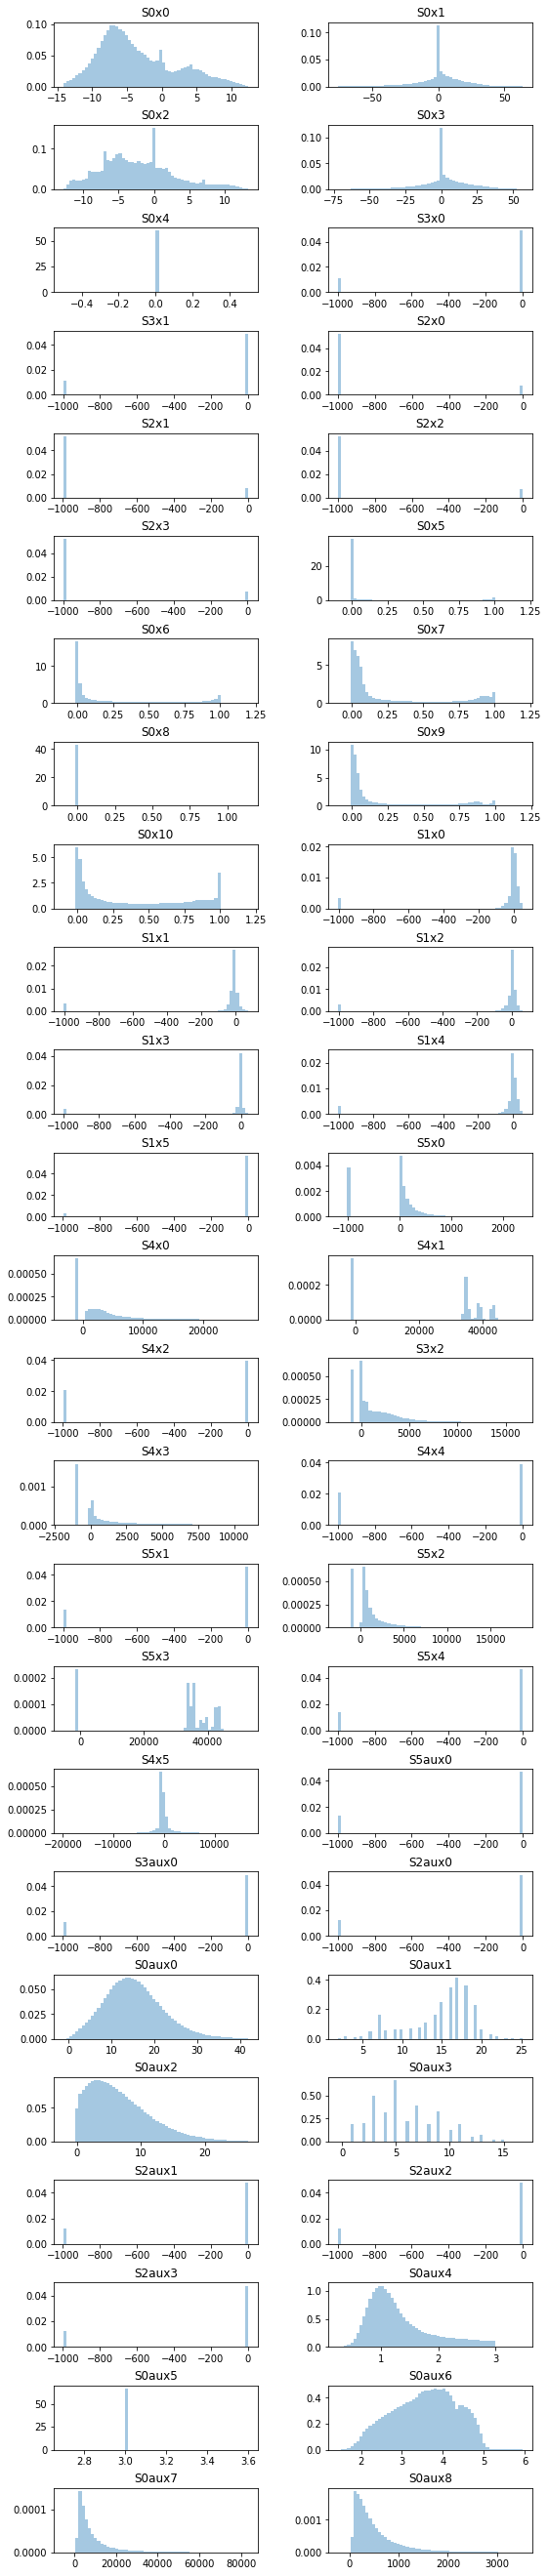

In [11]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./imgs/original_distribs.png")

# Разобъем индексы на train и test

In [12]:
# train test split
xgb_size = 0.1
data_size = 0.9
idx_xgb, idx_data = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=xgb_size, test_size=data_size)

In [13]:
xgb_data = df.iloc[idx_xgb]
df = df.iloc[idx_data]

In [14]:
len(idx_xgb)

327230

In [15]:
# train test split
train_size = 0.1
test_size = 0.9
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [16]:
df.shape, idx_train.shape, idx_test.shape

((2945074, 51), (294507,), (2650567,))

## Переведем значения признаков в отрезок $[-1, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [16]:
df_scaled = df.copy()

In [17]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = std_scaler.transform(df[var].values.reshape(-1, 1))
    
    # normalize with MaxAbsScaler
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = max_scaler.transform(df_scaled[var].values.reshape(-1, 1))
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

CPU times: user 1.19 s, sys: 12 ms, total: 1.2 s
Wall time: 1.2 s


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 13.4 s, sys: 5.16 s, total: 18.5 s
Wall time: 12.3 s


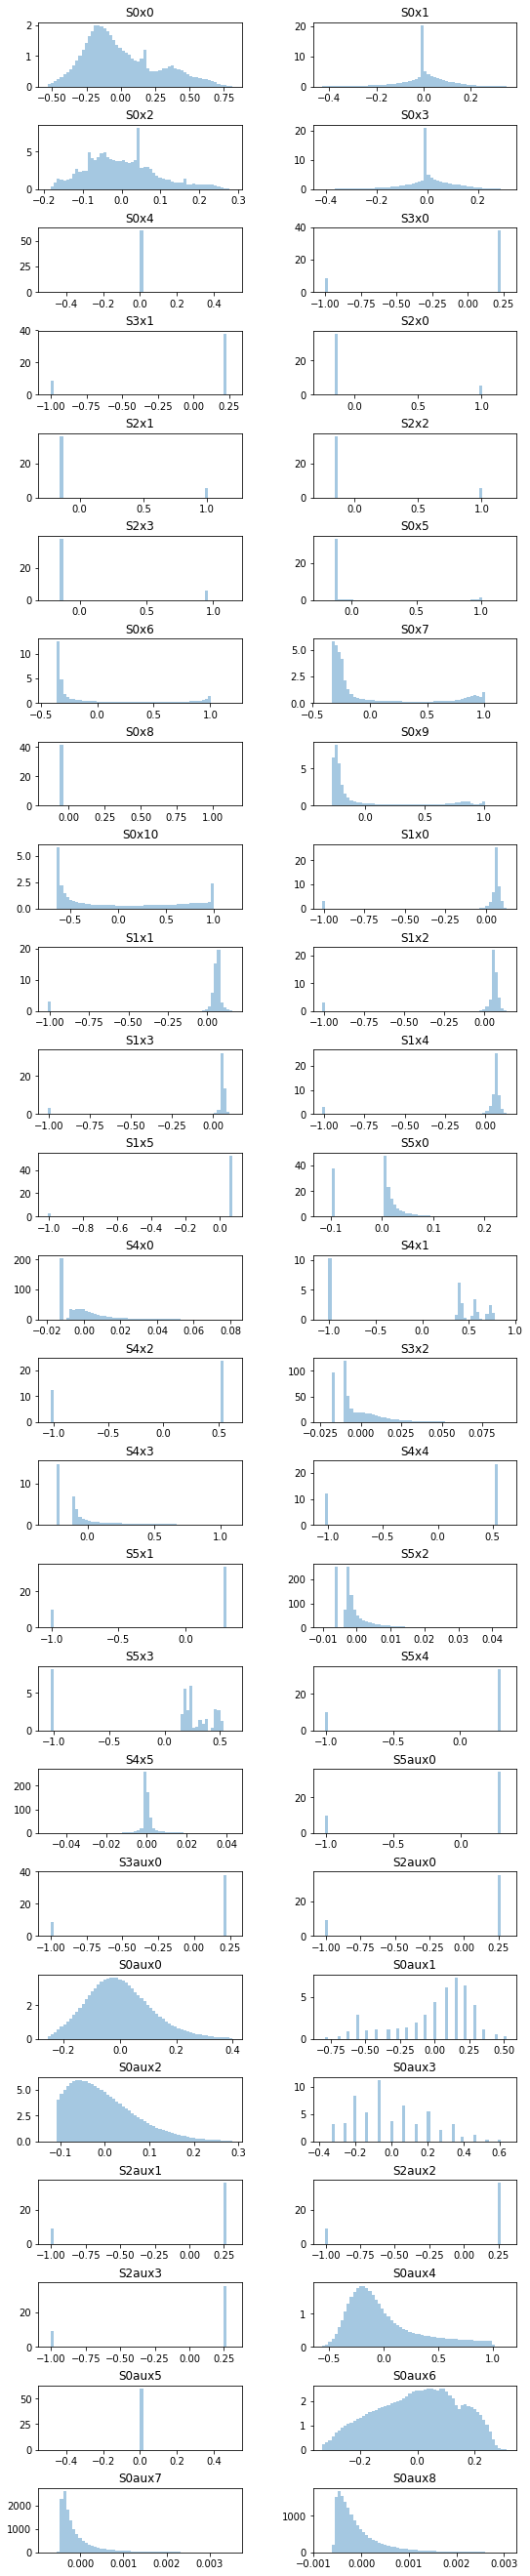

In [20]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

## Зададим архитектуру автоэнкодера

In [17]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])

    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)

    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Обучим автоэнкодер

In [18]:
l_encoding_dim = [3, 6, 9]

In [30]:
l_score = []
val_size = 0.1

train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]

train_input = train[vars_list_input].values
train_aux   = train[vars_list_aux].values
train_MC    = train[vars_list_MC].values

test_input = test[vars_list_input].values
test_aux   = test[vars_list_aux].values
test_MC    = test[vars_list_MC].values

NameError: name 'df_scaled' is not defined


  0%|          | 0/3 [00:00<?, ?it/s]

encoding_dim :  3
Train on 265056 samples, validate on 29451 samples
Epoch 1/30
265056/265056 [==============================] - 15s 57us/step - loss: 0.0108 - val_loss: 0.0049
Epoch 2/30
265056/265056 [==============================] - 15s 57us/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/30
265056/265056 [==============================] - 15s 56us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 4/30
265056/265056 [==============================] - 15s 56us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 5/30
265056/265056 [==============================] - 15s 56us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/30
265056/265056 [==============================] - 15s 56us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/30
265056/265056 [==============================] - 17s 65us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/30
265056/265056 [==============================] - 19s 70us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/30
265056/265056 [==============================] - 18s 70u


 33%|███▎      | 1/3 [08:56<17:53, 536.79s/it]




encoding_dim :  6
Train on 265056 samples, validate on 29451 samples
Epoch 1/30
265056/265056 [==============================] - 19s 72us/step - loss: 0.0058 - val_loss: 0.0032
Epoch 2/30
265056/265056 [==============================] - 19s 70us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/30
265056/265056 [==============================] - 19s 71us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/30
265056/265056 [==============================] - 19s 70us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/30
265056/265056 [==============================] - 19s 70us/step - loss: 0.0011 - val_loss: 9.7380e-04
Epoch 6/30
265056/265056 [==============================] - 19s 70us/step - loss: 8.8021e-04 - val_loss: 8.0101e-04
Epoch 7/30
265056/265056 [==============================] - 19s 70us/step - loss: 7.9387e-04 - val_loss: 7.9242e-04
Epoch 8/30
265056/265056 [==============================] - 19s 71us/step - loss: 7.3542e-04 - val_loss: 7.1047e-04
Epoch 9/30
265056/265056 [==========


 67%|██████▋   | 2/3 [19:53<09:56, 596.52s/it]




encoding_dim :  9
Train on 265056 samples, validate on 29451 samples
Epoch 1/30
265056/265056 [==============================] - 18s 67us/step - loss: 0.0030 - val_loss: 0.0012
Epoch 2/30
265056/265056 [==============================] - 17s 66us/step - loss: 0.0010 - val_loss: 8.6672e-04
Epoch 3/30
265056/265056 [==============================] - 17s 65us/step - loss: 7.8571e-04 - val_loss: 6.8272e-04
Epoch 4/30
265056/265056 [==============================] - 17s 65us/step - loss: 6.3585e-04 - val_loss: 5.6693e-04
Epoch 5/30
265056/265056 [==============================] - 17s 66us/step - loss: 5.2960e-04 - val_loss: 4.4811e-04
Epoch 6/30
265056/265056 [==============================] - 17s 65us/step - loss: 4.1621e-04 - val_loss: 3.4262e-04
Epoch 7/30
265056/265056 [==============================] - 17s 65us/step - loss: 3.3463e-04 - val_loss: 2.8341e-04
Epoch 8/30
265056/265056 [==============================] - 17s 65us/step - loss: 2.5903e-04 - val_loss: 2.2330e-04
Epoch 9/30
2


100%|██████████| 3/3 [27:15<00:00, 545.09s/it]





CPU times: user 32min 46s, sys: 8min 1s, total: 40min 47s
Wall time: 27min 15s


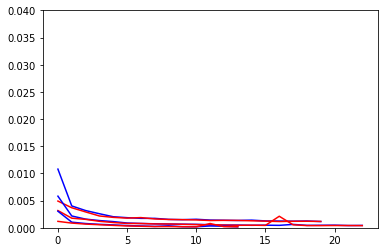

In [24]:
%%time
nb_epoch = 30
batch_size = 128
n_layers = 4
thickness = 6

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}   
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_autoencoder_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )
    
    checkpointer = keras.callbacks.ModelCheckpoint(
                    filepath="model_old_ratio10_{}.hdf5".format(encoding_dim), 
                    verbose=0, 
                    save_best_only=True)

    history = autoencoder.fit(
        [train_input, train_aux], train_input,
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_size, callbacks =[early_stopping, tensorboard, checkpointer]
    )
    
    autoencoder.load_weights("model_old_ratio10_{}.hdf5".format(encoding_dim))

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder.predict([encoded_test, test_aux])

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)

    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
    print("\n\n")

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

## Сохраненим score, сжимаемые переменные, test и decoded(после обратного масштабирования)

In [83]:
test[vars_list_aux+["pid"]].to_csv("./data/aux_test_old.csv")

In [35]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict's] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score[1:]
retain_dict['vars_list_input'] = vars_list_input

In [36]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [37]:
# %%time
for i, var in enumerate(vars_list_input):
    test_input_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[:, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    test_aux_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[:, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

In [38]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        tmp_decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [20]:
for i, var in enumerate(vars_list_input + vars_list_aux):
    joblib.dump(scalers[var]['std'], os.path.join('preprocessors', "scaler_std_"+var) + ".pkl")
    joblib.dump(scalers[var]['max'], os.path.join('preprocessors', "scaler_max_"+var) + ".pkl")

In [39]:
pickle.dump(retain_dict, open("retain_dict_old_{}.p".format(TYPE), "wb"))

In [30]:
for encoding_dim in l_encoding_dim:
    df_temp_enc = pd.DataFrame(save_encoded_dict[encoding_dim])
    df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=list(range(encoding_dim))+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
    df_temp_full_enc.to_csv("./data/df_old_encoded_ratio10_{}.csv".format(encoding_dim))
    
    df_temp_dec = pd.DataFrame(save_decoded_dict_dec[encoding_dim], columns=vars_list_input)
    df_temp_full_dec = pd.DataFrame(np.concatenate([df_temp_dec, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=vars_list_input+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
    df_temp_full_dec.to_csv("./data/df_old_decoded_ratio10_{}.csv".format(encoding_dim))

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [19]:
#Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check

pids = ['a', 'b', 'c', 'd', 'e']

retain_dict = pickle.load( open( "retain_dict_old_{}.p".format(TYPE), "rb" ) )
test_input = retain_dict.pop("test_input")
test_input_dec = retain_dict.pop("test_input_dec")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")
l_score = retain_dict.pop("l_score")
save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")
vars_list_input = retain_dict.pop("vars_list_input")

l_encoding_dim = list(save_decoded_dict.keys())

******************** 3 ********************


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


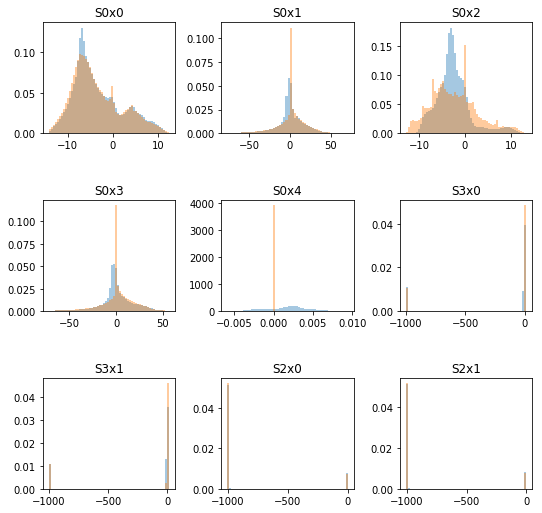

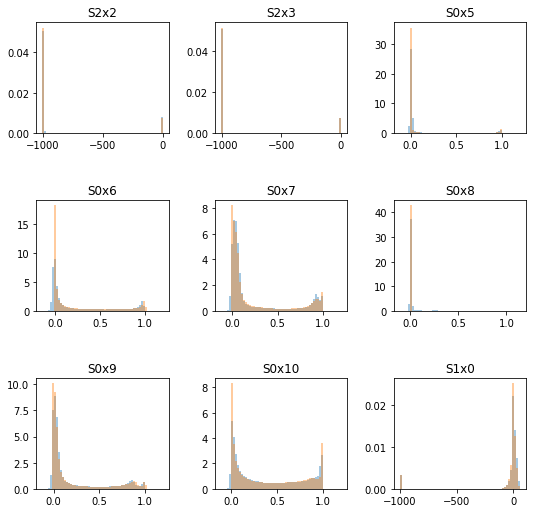

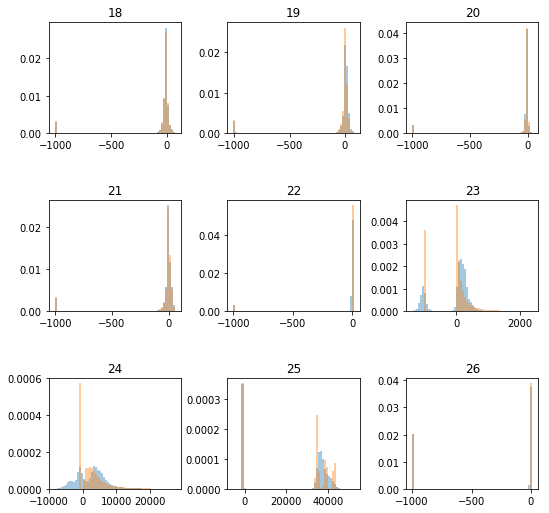

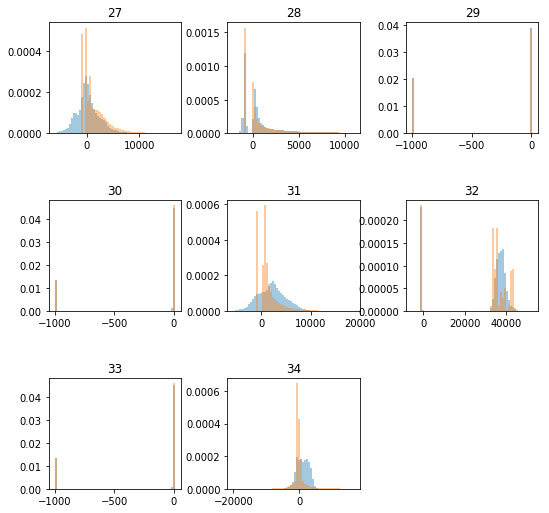

******************** 6 ********************


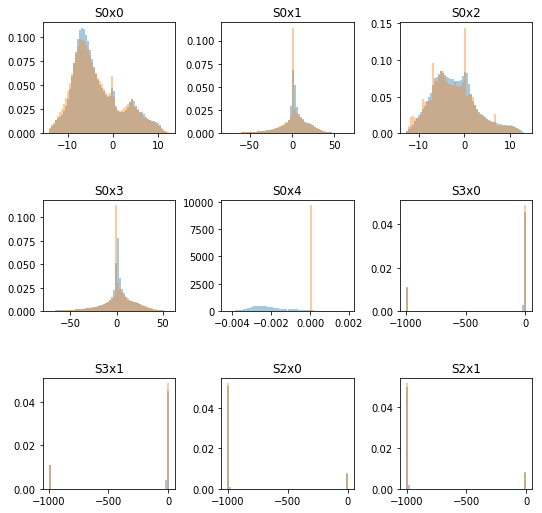

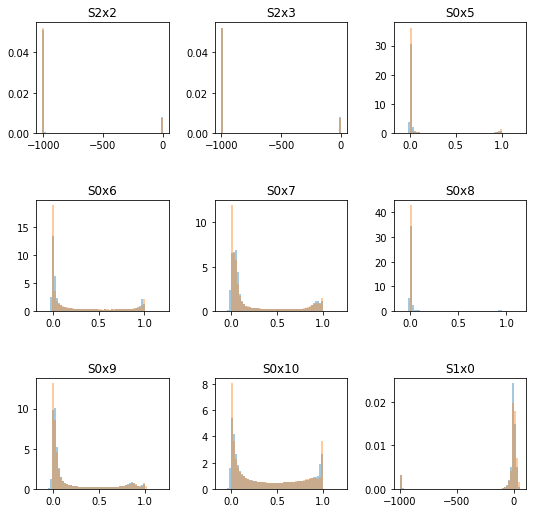

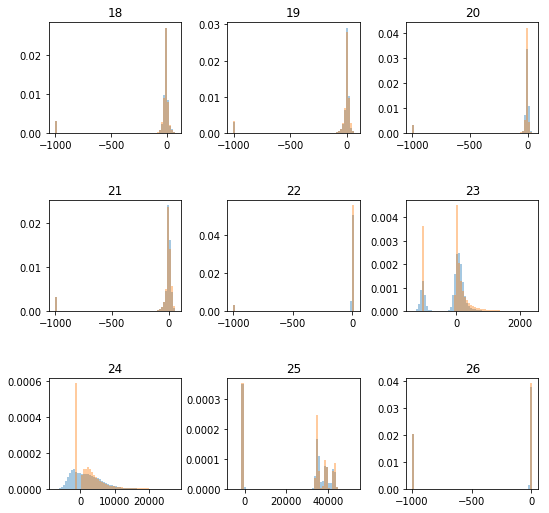

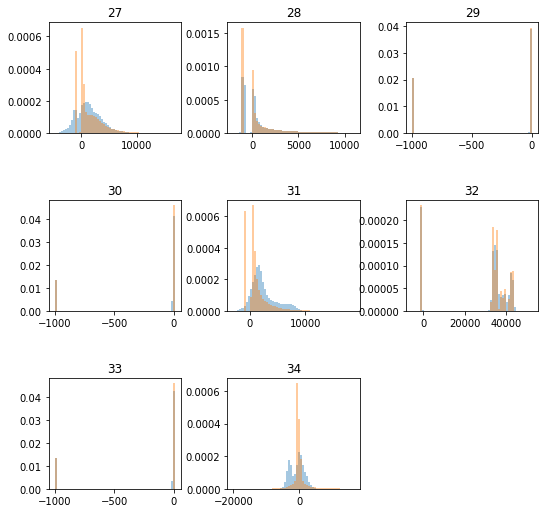

******************** 9 ********************


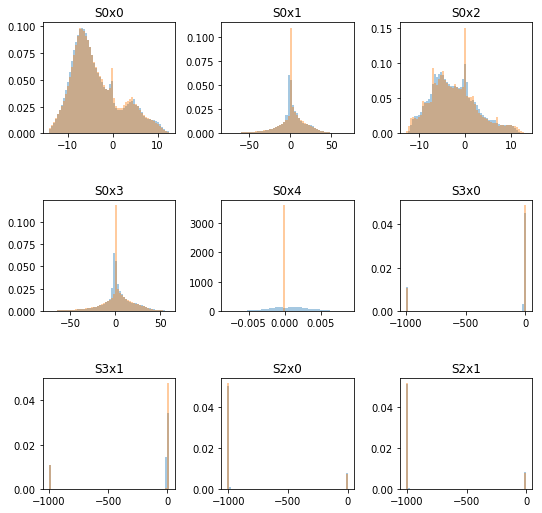

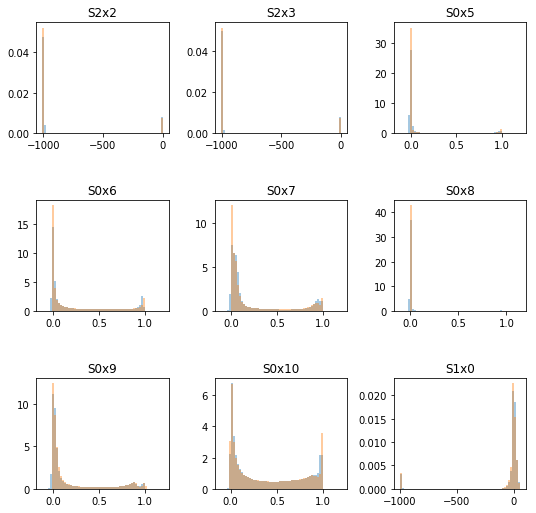

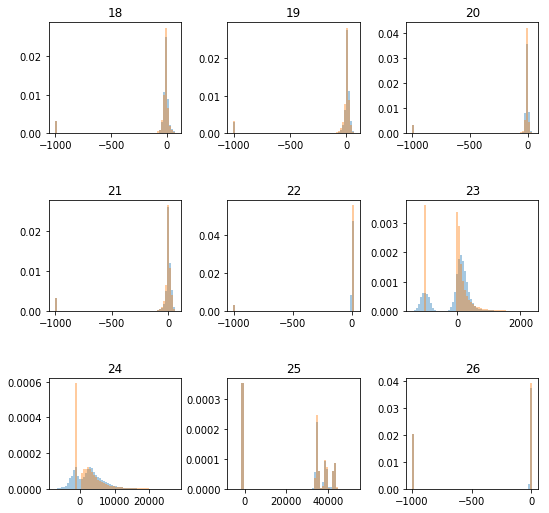

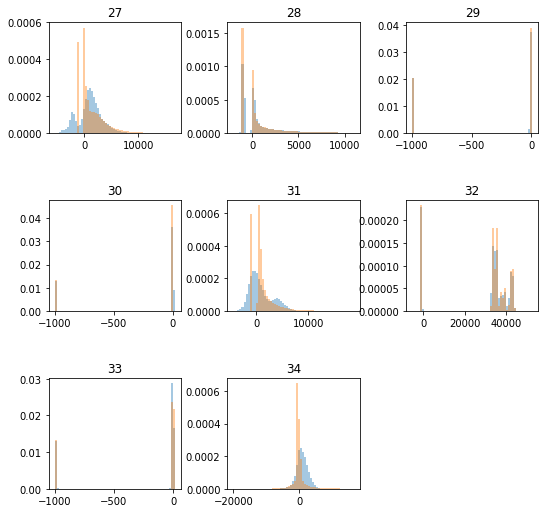

In [22]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in l_encoding_dim:
    # if you don't care about the names of the features uncomment the following line
#     print_features_histograms(
#         pd.DataFrame(save_decoded_dict_dec[encoding_dim]), 
#         target=pd.DataFrame(test_input_dec)
#     )
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim])
    df_temp_input = pd.DataFrame(test_input_dec)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, save_dir="./imgs/",
        save_filename="_{1}_orig_uncom_distribs_{0}.png".format(TYPE, encoding_dim)
    )
    plt.show()

Зависимость MSE от encoding_dim

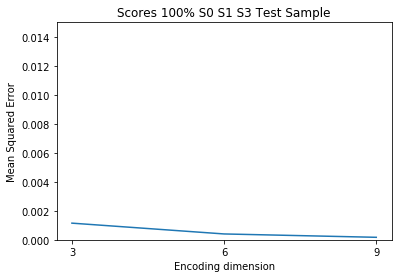

In [23]:
# Plotting the training loss (linear plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.plot(l_encoding_dim, l_score)
plt.title("Scores 100% S0 S1 S3 Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
plt.ylim(0, max(l_score)*1.2)
plt.ylim(0, 0.015)
plt.savefig("./imgs/scores_{}.png".format(TYPE))

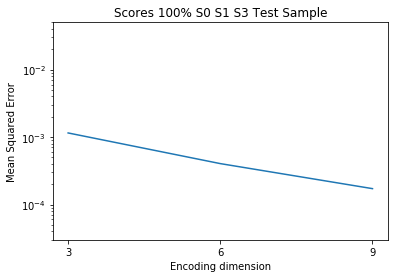

In [24]:
# Plotting the training loss (log plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.semilogy(l_encoding_dim, l_score)
plt.title("Scores 100% S0 S1 S3 Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0.00003, 0.05)
plt.savefig("./imgs/scores_log_{}.png".format(TYPE))

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Тестирование автоэнкодера на задаче классификации

In [25]:
from helpers import *

In [26]:
xgb_input = xgb_data[vars_list_input].values
xgb_aux   = xgb_data[vars_list_aux].values
xgb_MC    = xgb_data[vars_list_MC].values

In [27]:
le = LabelEncoder()
y = le.fit_transform(xgb_MC[:, 0])

In [28]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [29]:
xgb_input.shape, y.shape, xgb_MC.shape, xgb_data.shape

((327230, 35), (327230,), (327230, 1), (327230, 51))

Разобьем данные, выделенные для xgboost, на train и test

In [32]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(xgb_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = xgb_input[idx_train_clf], xgb_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_aux, X_test_aux = xgb_aux[idx_train_clf], xgb_aux[idx_test_clf]

## %%%%%%%%%%%%

### тестовые xgb данные through AE

In [35]:
orig_test_old = pd.DataFrame(np.concatenate([X_test, X_test_aux], axis=1), columns=vars_list_input+vars_list_aux)
orig_test_old["pid"] = y_test
# orig_test_old.to_csv("./data/orig_test_old.csv")

In [33]:
scalers = {var: {} for var in vars_list_input+vars_list_aux}
for i, var in enumerate( vars_list_input+vars_list_aux):
    scalers[var]['std'] = joblib.load(os.path.join('preprocessors', "scaler_std_"+var) + ".pkl")
    scalers[var]['max'] = joblib.load(os.path.join('preprocessors', "scaler_max_"+var) + ".pkl")

In [36]:
orig_test_old_scaled = orig_test_old.copy()
for var in (vars_list_input + vars_list_aux):
    orig_test_old_scaled[var] = scalers[var]["std"].transform(orig_test_old[var].values.reshape(-1, 1))
    orig_test_old_scaled[var] = scalers[var]["max"].transform(orig_test_old_scaled[var].values.reshape(-1, 1))

In [65]:
orig_test_old_scaled["pid"] = orig_test_old["pid"]
orig_test_old_scaled[vars_list_aux+["pid"]].to_csv("./data/aux_test_old.csv")

In [61]:
for encoding_dim in l_encoding_dim:
    autoencoder, encoder, decoder = create_autoencoder_aux(
            35, encoding_dim, 
            n_aux_features=15, n_layers=4, thickness=6
        )

    autoencoder.load_weights("./models/model_old_ratio10_{}.hdf5".format(encoding_dim))

    encoded_test = encoder.predict([orig_test_old_scaled[vars_list_input].values, orig_test_old_scaled[vars_list_aux].values])
    
    encoded = pd.DataFrame(np.concatenate([encoded_test, orig_test_old[vars_list_aux]], axis=1), columns=list(range(encoding_dim))+vars_list_aux)
    encoded["pid"] = orig_test_old["pid"]
    encoded.to_csv('./data/ae_encoded_test_pid_{}_old.csv'.format(encoding_dim))
    
    decoded_test = decoder.predict([encoded_test, orig_test_old_scaled[vars_list_aux].values])
    
    decoded_unscaled = decoded_test.copy()
    for i, var in enumerate(vars_list_input):
        decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
        
    
    decoded_unscaled = pd.DataFrame(np.concatenate([decoded_unscaled, orig_test_old[vars_list_aux]], axis=1), columns=vars_list_input+vars_list_aux)
    decoded_unscaled["pid"] = orig_test_old["pid"]
    decoded_unscaled.to_csv('./data/ae_test_pid_{}_old.csv'.format(encoding_dim))

## %%%%%%%%%%%

In [42]:
clf_name = "XGBoost_old_{}".format(9)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
# clf.fit(X_train, y_train)
# joblib.dump(clf, os.path.join('xgboost', clf_name) + ".pkl")
clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

In [53]:
X_test_dec_dict = {}
for encoding_dim in l_encoding_dim:
    X_test_dec_dict[encoding_dim] = pd.read_csv('./data/ae_test_pid_{}_old.csv'.format(encoding_dim))
    y_test_dec = X_test_dec_dict[encoding_dim]["pid"].values
    X_test_dec_dict[encoding_dim] = X_test_dec_dict[encoding_dim][vars_list_input].values

In [31]:
path_to_metrics = './metrics/'
metrics_dir_name = "ae_old"

metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

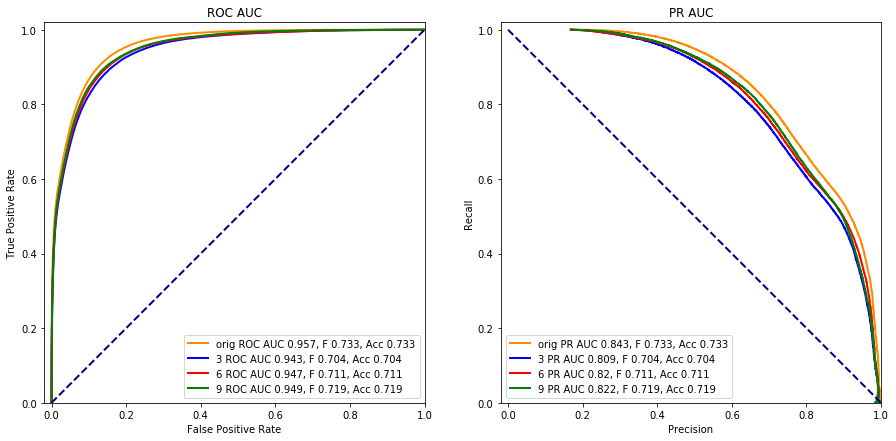

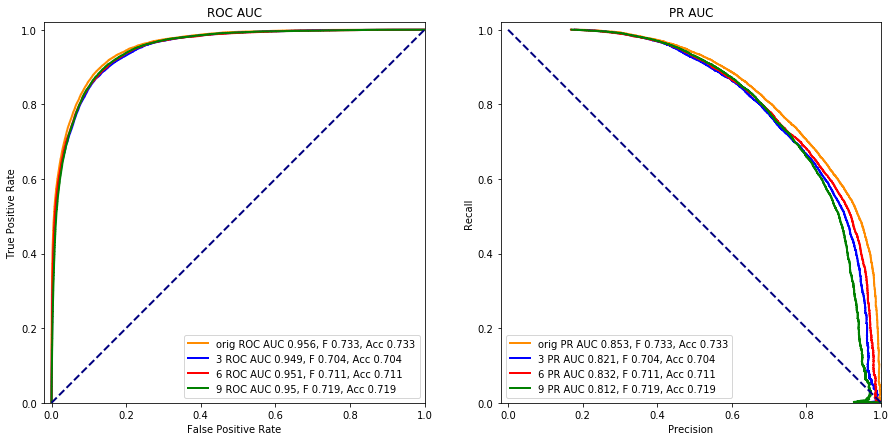

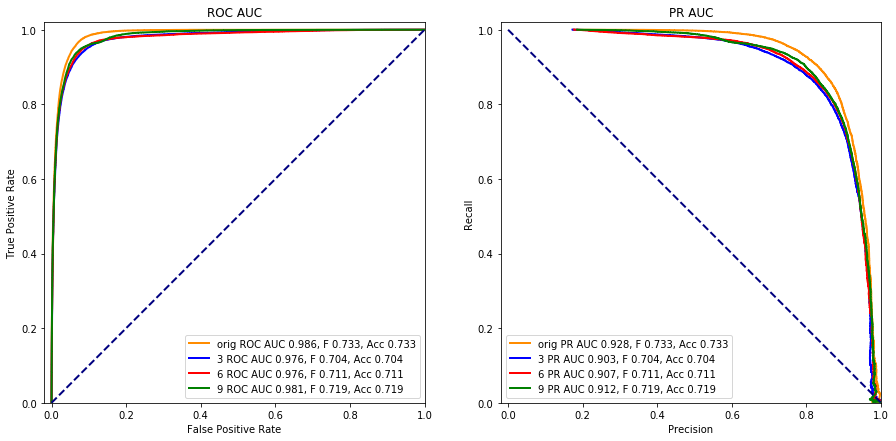

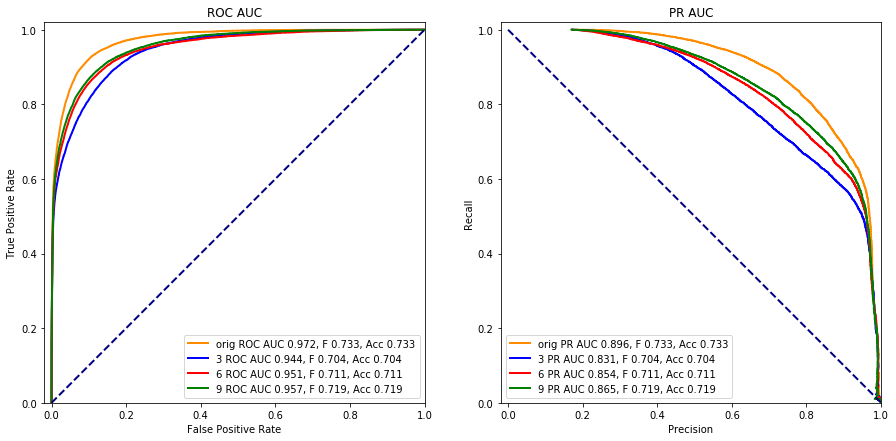

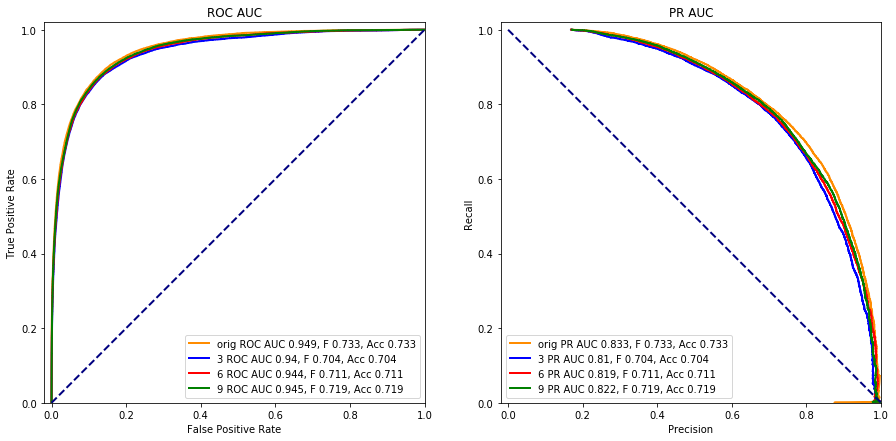

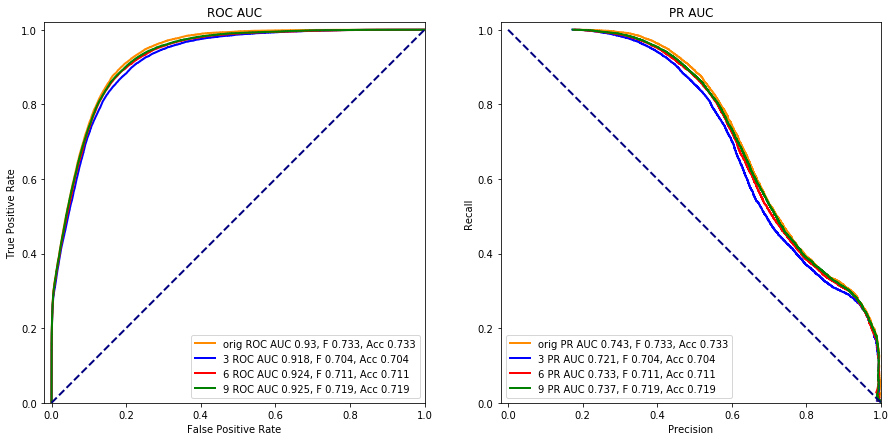

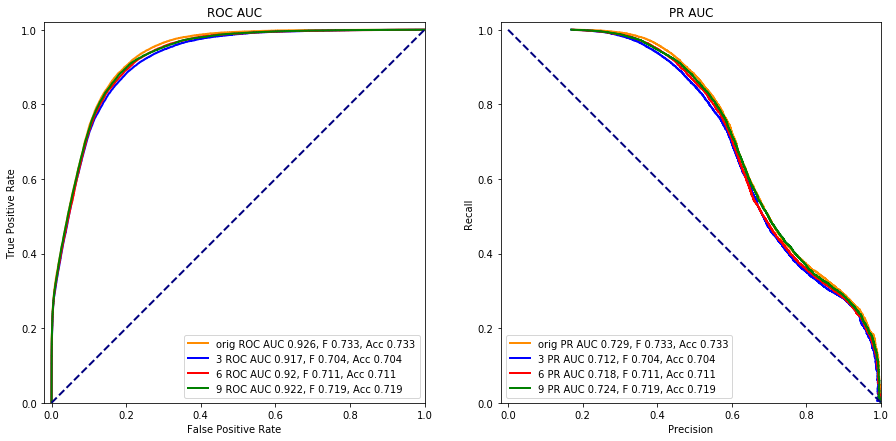



100%|██████████| 4/4 [01:31<00:00, 22.83s/it]



In [54]:
import os
for encoding_dim in tqdm(["orig"] + l_encoding_dim):
    if encoding_dim == "orig":
        y_proba = clf.predict_proba(X_test)
        y_real = y_test
    else:
        y_proba = clf.predict_proba(X_test_dec_dict[encoding_dim])
        y_real = y_test_dec
    y_pred = np.argmax(y_proba, axis=1)
    y_bin = label_binarize(y_real, classes=np.unique(y_real))
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_real):
        idx = np.where(y_real == pid_label)[0]
        cur_y = np.where(y_real == pid_label, np.ones_like(y_real), np.zeros_like(y_real))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_real, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_real, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     fig.savefig('./plots/{}_dim_{}.png'.format(MODEL_NAME, encoding_dim))

In [55]:
# from collections import Counter
# metrics_dict = {
#         # ROC
#         'fpr': defaultdict(Counter),
#         'tpr': defaultdict(Counter),
#         'roc_auc': defaultdict(Counter),

#         # PR
#         'precision': defaultdict(Counter), 
#         'recall': defaultdict(Counter),
#         'pr_auc': defaultdict(Counter),

#         'f_measure': Counter(),
#         'acc': Counter()
#     } 

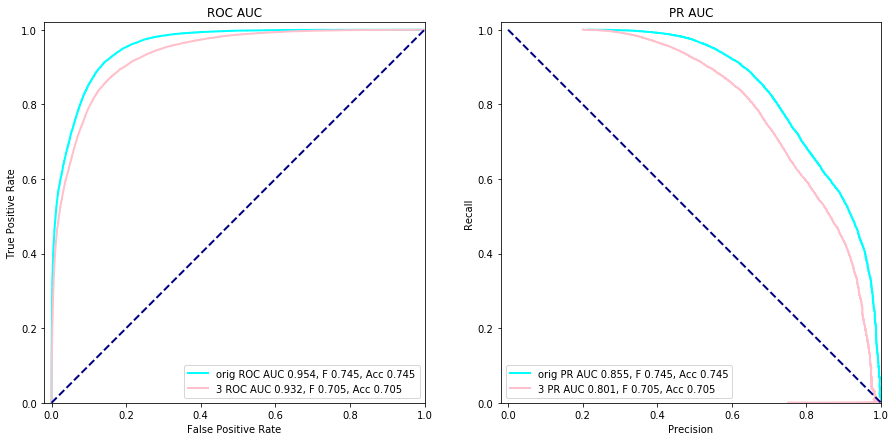

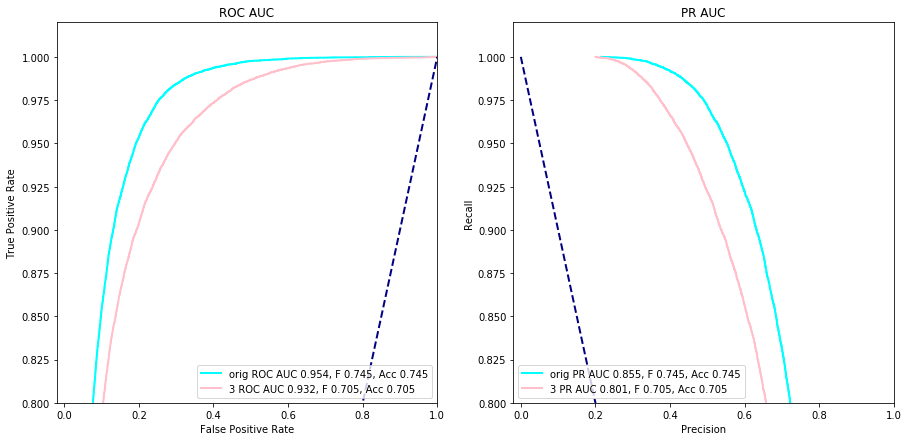

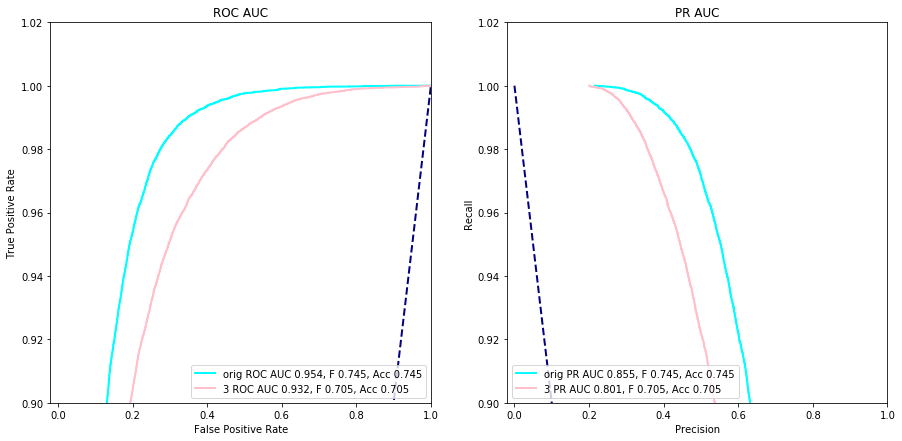

100%|██████████| 2/2 [03:02<00:00, 91.20s/it] 


In [33]:
# data_size = 200000
# from collections import Counter
# from sklearn.preprocessing import RobustScaler

# for i in range(1, 11):
#     _, idx = train_test_split(np.arange(test_input.shape[0]), stratify=y, 
#                                                    random_state=i, test_size=data_size)
#     test_input_ = test_input[idx]
#     y_ = y[idx]
#     test_MC_ = test_MC[idx]
    
    
    
#     test_size = 30000

#     idx_train_clf, idx_test_clf = train_test_split(np.arange(test_input_.shape[0]), stratify=y_, 
#                                                    random_state=i+10, test_size=test_size)
#     X_train, X_test = test_input_[idx_train_clf], test_input_[idx_test_clf]
#     y_train, y_test = y_[idx_train_clf], y_[idx_test_clf]
    
#     scaler = RobustScaler().fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)

#     X_train_enc_dict, X_test_enc_dict = {}, {}
#     for encoding_dim in l_encoding_dim:
#         X_train_enc_dict[encoding_dim] = save_encoded_dict[encoding_dim][idx][idx_train_clf]
#         X_test_enc_dict[encoding_dim] = save_encoded_dict[encoding_dim][idx][idx_test_clf]   
        
#         scaler = RobustScaler().fit(X_train_enc_dict[encoding_dim])
#         X_train_enc_dict[encoding_dim] = scaler.transform(X_train_enc_dict[encoding_dim])
#         X_test_enc_dict[encoding_dim] = scaler.transform(X_test_enc_dict[encoding_dim])
    
    
#     for encoding_dim in tqdm(["orig"] + [3]):
#         clf_name = "XGBoost_{}".format(encoding_dim)
#         clf = xgb.XGBClassifier(nthread=-1, seed=111)

#         if encoding_dim == "orig":
#             clf.fit(X_train, y_train)
#             y_proba = clf.predict_proba(X_test)
#         else:
#             clf.fit(X_train_enc_dict[encoding_dim], y_train)
#             y_proba = clf.predict_proba(X_test_enc_dict[encoding_dim])
#         y_pred = np.argmax(y_proba, axis=1)
#         y_bin = label_binarize(y_test, classes=np.unique(y_test))
            
#         x, z, _ = roc_curve(y_bin.ravel(), y_proba.ravel(), drop_intermediate=False)

#         all_metrics_dict['fpr'][encoding_dim]["micro"] = x 
#         all_metrics_dict['tpr'][encoding_dim]["micro"] = z
        
#         all_metrics_dict['precision'][encoding_dim]["micro"], all_metrics_dict['recall'][encoding_dim]["micro"], _ = \
#             precision_recall_curve(y_bin.ravel(), y_proba.ravel())

#         metrics_dict['roc_auc'][encoding_dim]["micro"] += auc(x, z)
#         metrics_dict['pr_auc'][encoding_dim]["micro"] += average_precision_score(y_bin.ravel(), y_proba.ravel())

#         metrics_dict['f_measure'][encoding_dim] += f1_score(y_test, y_pred, average='micro')
#         metrics_dict['acc'][encoding_dim] += accuracy_score(y_test, y_pred)
        
#         all_metrics_dict['roc_auc'][encoding_dim]["micro"] = metrics_dict['roc_auc'][encoding_dim]["micro"] / i
#         all_metrics_dict['pr_auc'][encoding_dim]["micro"] = metrics_dict['pr_auc'][encoding_dim]["micro"] / i
#         all_metrics_dict['f_measure'][encoding_dim] = metrics_dict['f_measure'][encoding_dim] / i
#         all_metrics_dict['acc'][encoding_dim] = metrics_dict['acc'][encoding_dim] / i

#         # Save
#         dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)

#         # Plot
#         display.clear_output(wait=True)
#         plot_metrics(all_metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
#         plot_metrics(all_metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
#         plot_metrics(all_metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

------------------